<a href="https://colab.research.google.com/github/HUYR01/Federated-Learning-Based-Intrusion-Detection-System/blob/main/CNN_Transfer.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
import os
drive.mount("/content/drive", force_remount=True)

Mounted at /content/drive


In [ ]:
import torch, copy
import argparse, json
import datetime
import os
import logging
import random

logging.getLogger().setLevel(logging.INFO)

no_models=2 #客户端模型数量
global_epochs=5  #全局迭代次数
local_epochs= 2 #局部迭代次数
#k =5  #选择局部模型的个数
batch_size=1024 #本地训练每一轮的样本数
lr = 0.001
momentum= 0.0001
lamda= 0.1

### CNN模型

In [ ]:
import os
import logging

import pandas as pd
import tensorflow.keras as keras

from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.utils import plot_model

# Log setting
logging.basicConfig(format="%(asctime)s %(levelname)s %(message)s", datefmt="%H:%M:%S", level=logging.INFO)

# Change display.max_rows to show all features.
pd.set_option("display.max_rows", 85)

INFO:numexpr.utils:NumExpr defaulting to 2 threads.


In [ ]:
PROCESSED_DIR_PATH = "/content/drive/My Drive/CICIDS/ProcessedDataset"
MODEL_DIR_PATH = "/content/drive/My Drive/CICIDS/Model"

In [ ]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

from sklearn.metrics import classification_report
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import f1_score


def preprocessing(df: pd.DataFrame) -> (np.ndarray, np.ndarray):
    # Shuffle the dataset打乱数据集
    df = df.sample(frac=1)

    # 划分特征和标签
    x = df.iloc[:, df.columns != 'Label']
    y = df[['Label']].to_numpy()

    # 将特征归一化到[0,1]区间
    scaler = MinMaxScaler()
    x = scaler.fit_transform(x)

    return x, y


def reshape_dataset_cnn(x: np.ndarray) -> np.ndarray:
    # Add padding columns添加填充列（每一行末尾填充3个零）
    result = np.zeros((x.shape[0], 81))
    result[:, :-3] = x

    # Reshaping dataset
    result = np.reshape(result, (result.shape[0], 9, 9))
    result = result[..., tf.newaxis]#加一个维度
    return result


def plot_history(history: tf.keras.callbacks.History):
    # summarize history for accuracy
    plt.plot(history.history['sparse_categorical_accuracy'])
    plt.plot(history.history['val_sparse_categorical_accuracy'])
    plt.title('model2 accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.show()

    # summarize history for loss
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('model2 loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.show()


def evaluation(model: keras.Model, x_test: np.ndarray, y_test: np.ndarray):
    score = model.evaluate(x_test, y_test, verbose=False)
    logging.info('Evaluation:\nLoss: {}\nAccuracy : {}\n'.format(score[0], score[1]))

    # F1 score
    y_pred = model.predict(x_test, batch_size=1024, verbose=False)
    y_pred = np.argmax(y_pred, axis=1)
    # 计算 F1 分数
    f1 = f1_score(y_test, y_pred, average='weighted')

    logging.info("\n{}".format(classification_report(y_test, y_pred)))
    #将 F1 分数记录到日志中
    logging.info('F1 score: {:.2f}\n'.format(f1))

In [ ]:
def create_cnn_model() -> keras.Model:
    # Creating layers
    inputs = keras.layers.Input(shape=(9, 9, 1))
    x = keras.layers.Conv2D(120, 2, activation='relu', padding="same")(inputs)#卷积核数量120，长宽=2
    x = keras.layers.Conv2D(60, 3, activation='relu', padding="same")(x)
    x = keras.layers.Conv2D(30, 4, activation='relu', padding="same")(x)
    x = keras.layers.Flatten()(x)
    outputs = keras.layers.Dense(11, activation='softmax')(x)#全连接层
    cnn_model = keras.Model(inputs=inputs, outputs=outputs, name='cnn')

    # Compile layers
    cnn_model.compile(loss='sparse_categorical_crossentropy',
                      metrics=['sparse_categorical_accuracy'],
                      optimizer='adam')

    return cnn_model



### 数据读取

In [ ]:
from sklearn.model_selection import train_test_split
import numpy as np
import itertools

#训练数据读取
data = pd.read_csv(os.path.join(PROCESSED_DIR_PATH, 'shrink_train_MachineLearningCVE.csv'), skipinitialspace=True)
#只保留9之外的数据
ls = [0,1,2,3,5,4,6,7,10,11,12]
df = data[data['Label'].isin(ls)].copy()
df.loc[df['Label'] ==11, 'Label'] = 8
df.loc[df['Label'] ==12, 'Label'] = 9

# ls = [1]
# group1 = data[data['Label'].isin(ls)].copy()
# group2 = data[data['Label'].isin(ls)].copy()



# # 计算每种Label值的数据个数
# label_counts = df['Label'].value_counts()


# # 遍历每种Label值，取出20%的数据添加到新数据中
# for label, count in label_counts.items():
#     # 计算要取出的数据个数
#     sample_size = count
#     # 从这种Label值的数据中随机选择20%
#     selected_data = df[df['Label'] == label].sample(n=sample_size, random_state=42)
#     # 将选择的数据按Label对半分成两部分，添加到新数据中
#     half_size = int(sample_size / 2)
#     group1 = pd.concat([group1, selected_data.iloc[:half_size]])
#     group2 = pd.concat([group2, selected_data.iloc[half_size:]])
#     # 从原数据中删除这些数据
#     df.drop(selected_data.index, inplace=True)

# # 打印新数据和剩余数据的信息
# print('group1 ({} samples):'.format(len(group1)))
# print(group1['Label'].value_counts())
# print('group1 ({} samples):'.format(len(group2)))
# print(group2['Label'].value_counts())
# print('Remaining data ({} samples):'.format(len(df)))
# print(df['Label'].value_counts())


group1 (30343 samples):
3     4117
0     3500
4     3500
10    3500
2     3500
7     3175
8     2359
6     2318
5     2199
1     1573
9      602
Name: Label, dtype: int64
group1 (30347 samples):
3     4118
0     3500
4     3500
10    3500
2     3500
7     3175
8     2359
6     2319
5     2200
1     1573
9      603
Name: Label, dtype: int64
Remaining data (0 samples):
Series([], Name: Label, dtype: int64)


### 迁移学习

In [ ]:
# Training
logging.info("*** TRAINING START ***")
model = create_cnn_model()

# Define the checkpoint filepath
cp_path = os.path.join(MODEL_DIR_PATH, "model_weights_checkpoint.h5")

# Define the ModelCheckpoint callback
checkpoint = ModelCheckpoint(cp_path,save_freq='epoch')
callbacks_list = [checkpoint]

df = pd.read_csv(os.path.join(PROCESSED_DIR_PATH, 'train_MachineLearningCVE.csv'), skipinitialspace=True)
ls = [0,1,4,6,7,10,11,12]
df = df[df['Label'].isin(ls)].copy()
df.loc[df['Label'] ==11, 'Label'] = 8
df.loc[df['Label'] ==12, 'Label'] = 9
X, Y = preprocessing(df)
X = reshape_dataset_cnn(X)


history = model.fit(X, Y, validation_split=0.1, epochs=30, batch_size=1024, verbose=True,callbacks=callbacks_list)#0.1为验证集占比

INFO:root:*** TRAINING START ***


Epoch 1/30
1889/1889 [==============================] - 57s 24ms/step - loss: 0.1071 - sparse_categorical_accuracy: 0.9602 - val_loss: 0.0689 - val_sparse_categorical_accuracy: 0.9620
Epoch 2/30
1889/1889 [==============================] - 45s 24ms/step - loss: 0.0429 - sparse_categorical_accuracy: 0.9828 - val_loss: 0.0320 - val_sparse_categorical_accuracy: 0.9873
Epoch 3/30
1889/1889 [==============================] - 43s 23ms/step - loss: 0.0280 - sparse_categorical_accuracy: 0.9887 - val_loss: 0.0296 - val_sparse_categorical_accuracy: 0.9864
Epoch 4/30
1889/1889 [==============================] - 45s 24ms/step - loss: 0.0212 - sparse_categorical_accuracy: 0.9923 - val_loss: 0.0150 - val_sparse_categorical_accuracy: 0.9951
Epoch 5/30
1889/1889 [==============================] - 43s 23ms/step - loss: 0.0109 - sparse_categorical_accuracy: 0.9979 - val_loss: 0.0109 - val_sparse_categorical_accuracy: 0.9981
Epoch 6/30
1889/1889 [==============================] - 43s 23ms/step - loss: 0.

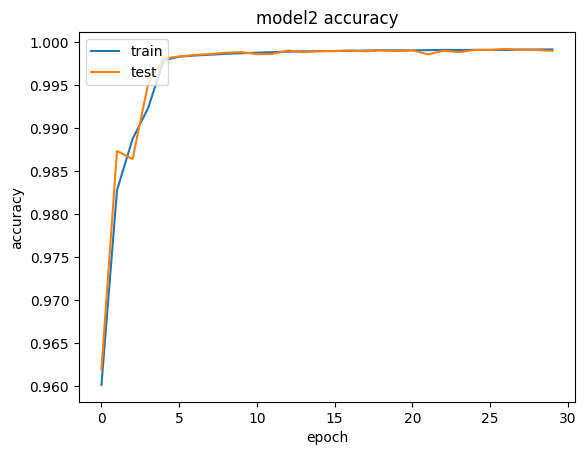

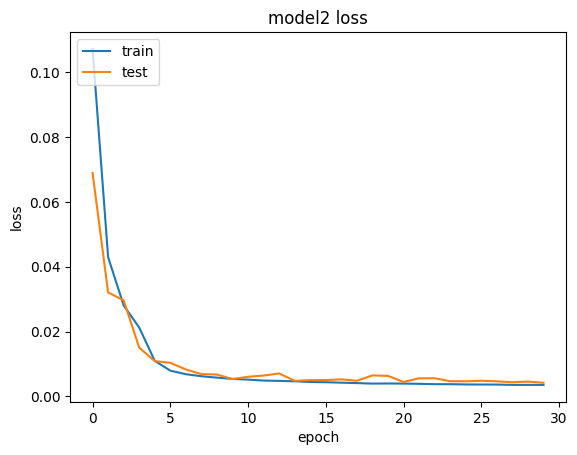

In [ ]:
# Save the model
model.save(os.path.join(MODEL_DIR_PATH, "model_weights-02-0.85.h5"))

plot_history(history)

In [ ]:
#测试数据读取

df = pd.read_csv(os.path.join(PROCESSED_DIR_PATH, 'test_MachineLearningCVE.csv'), skipinitialspace=True)
ls = [0,1,2,3,4,5,6,7,10,11,12]
df = df[df['Label'].isin(ls)]
df.loc[df['Label'] ==11, 'Label'] = 8
df.loc[df['Label'] ==12, 'Label'] = 9
logging.info("Class distribution\n{}".format(df.Label.value_counts()))
X_test, Y_test = preprocessing(df)
del df
X_test = reshape_dataset_cnn(X_test)

INFO:root:Class distribution
0     454620
4      46215
10     31786
2      25606
3       2058
7       1588
8       1179
6       1159
5       1100
1        393
9        302
Name: Label, dtype: int64


In [ ]:
import warnings
from keras.models import load_model
warnings.filterwarnings("ignore")
#模型评估
model=load_model(os.path.join(MODEL_DIR_PATH, "model_weights-02-0.85.h5"))
evaluation(model, X_test, Y_test)

INFO:root:Evaluation:
Loss: 1.0328915119171143
Accuracy : 0.9473256468772888

INFO:root:
              precision    recall  f1-score   support

           0       0.96      1.00      0.98    454620
           1       0.22      0.67      0.33       393
           2       0.00      0.00      0.00     25606
           3       0.00      0.00      0.00      2058
           4       0.86      1.00      0.93     46215
           5       0.00      0.00      0.00      1100
           6       0.73      0.91      0.81      1159
           7       0.93      1.00      0.97      1588
           8       0.95      1.00      0.97      1179
           9       0.66      0.99      0.79       302
          10       0.95      1.00      0.98     31786

    accuracy                           0.95    566006
   macro avg       0.57      0.69      0.61    566006
weighted avg       0.90      0.95      0.92    566006

INFO:root:F1 score: 0.92



In [ ]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.optimizers import Adam
from keras.models import load_model

model1 = load_model(os.path.join(MODEL_DIR_PATH, "model_weights-02-0.85.h5"))
model2 = load_model(os.path.join(MODEL_DIR_PATH, "model_weights-02-0.85.h5"))
# 定义联邦学习的超参数
learning_rate = 0.01  # 学习率
num_epochs = 10  # 迭代次数
batch_size = 32  # 批次大小

#数据处理
group1_X , group1_Y = preprocessing(group1)
group1_X = reshape_dataset_cnn(group1_X)

group2_X , group2_Y = preprocessing(group2)
group2_X = reshape_dataset_cnn(group2_X)


# 冻结模型中除输出层之外的所有层
for layer in model1.layers[:-2]:
    layer.trainable = False
model1.compile(loss='sparse_categorical_crossentropy',metrics=['sparse_categorical_accuracy'],optimizer=Adam(learning_rate=0.001))

# 冻结模型中除输出层之外的所有层
for layer in model2.layers[:-2]:
    layer.trainable = False
model2.compile(loss='sparse_categorical_crossentropy',metrics=['sparse_categorical_accuracy'],optimizer=Adam(learning_rate=0.001))


# 训练模型
history1_list=[]
history2_list=[]

for epoch in range(num_epochs):
    # 在节点1上训练模型

    history1=model1.fit(group1_X, group1_Y, validation_split=0.1, batch_size=32, epochs=3, verbose=True)
    history1_list.append(history1)

    # 在节点2上训练模型
    history2=model2.fit(group2_X, group2_Y, validation_split=0.1, batch_size=32, epochs=3, verbose=True)
    history2_list.append(history2)

    # 聚合模型参数
    global_weights = []
    for weights_1, weights_2 in zip(model1.get_weights(), model2.get_weights()):
        global_weights.append((weights_1/2) + (weights_2/2))

    # 在节点1和节点2上更新模型
    model1.set_weights(global_weights)
    model2.set_weights(global_weights)
    evaluation(model1, X_test, Y_test)


model1.save(os.path.join(MODEL_DIR_PATH, "model_1_weights-02-0.85.h5"))
model2.save(os.path.join(MODEL_DIR_PATH, "model_2_weights-02-0.85.h5"))

Epoch 1/3
854/854 [==============================] - 4s 4ms/step - loss: 0.3019 - sparse_categorical_accuracy: 0.9630 - val_loss: 0.0310 - val_sparse_categorical_accuracy: 0.9931
Epoch 2/3
854/854 [==============================] - 3s 4ms/step - loss: 0.0278 - sparse_categorical_accuracy: 0.9946 - val_loss: 0.0221 - val_sparse_categorical_accuracy: 0.9951
Epoch 3/3
854/854 [==============================] - 4s 5ms/step - loss: 0.0201 - sparse_categorical_accuracy: 0.9959 - val_loss: 0.0206 - val_sparse_categorical_accuracy: 0.9954
Epoch 1/3
854/854 [==============================] - 4s 4ms/step - loss: 0.3053 - sparse_categorical_accuracy: 0.9645 - val_loss: 0.0436 - val_sparse_categorical_accuracy: 0.9937
Epoch 2/3
854/854 [==============================] - 3s 4ms/step - loss: 0.0264 - sparse_categorical_accuracy: 0.9940 - val_loss: 0.0343 - val_sparse_categorical_accuracy: 0.9944
Epoch 3/3
854/854 [==============================] - 3s 4ms/step - loss: 0.0199 - sparse_categorical_accu

INFO:root:Evaluation:
Loss: 0.022991616278886795
Accuracy : 0.9936785101890564

INFO:root:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00    454620
           1       0.21      0.98      0.35       393
           2       1.00      0.97      0.99     25606
           3       0.96      0.95      0.96      2058
           4       1.00      1.00      1.00     46215
           5       0.84      0.45      0.59      1100
           6       0.98      0.99      0.98      1159
           7       0.99      1.00      1.00      1588
           8       0.99      1.00      0.99      1179
           9       0.98      0.19      0.32       302
          10       0.99      1.00      1.00     31786

    accuracy                           0.99    566006
   macro avg       0.90      0.87      0.83    566006
weighted avg       1.00      0.99      0.99    566006

INFO:root:F1 score: 0.99



Epoch 1/3
854/854 [==============================] - 3s 4ms/step - loss: 0.0217 - sparse_categorical_accuracy: 0.9953 - val_loss: 0.0193 - val_sparse_categorical_accuracy: 0.9951
Epoch 2/3
854/854 [==============================] - 3s 4ms/step - loss: 0.0161 - sparse_categorical_accuracy: 0.9964 - val_loss: 0.0183 - val_sparse_categorical_accuracy: 0.9964
Epoch 3/3
854/854 [==============================] - 5s 5ms/step - loss: 0.0147 - sparse_categorical_accuracy: 0.9964 - val_loss: 0.0209 - val_sparse_categorical_accuracy: 0.9951
Epoch 1/3
854/854 [==============================] - 4s 4ms/step - loss: 0.0197 - sparse_categorical_accuracy: 0.9950 - val_loss: 0.0257 - val_sparse_categorical_accuracy: 0.9937
Epoch 2/3
854/854 [==============================] - 3s 3ms/step - loss: 0.0162 - sparse_categorical_accuracy: 0.9958 - val_loss: 0.0322 - val_sparse_categorical_accuracy: 0.9941
Epoch 3/3
854/854 [==============================] - 3s 4ms/step - loss: 0.0147 - sparse_categorical_accu

INFO:root:Evaluation:
Loss: 0.022799234837293625
Accuracy : 0.9931926727294922

INFO:root:
              precision    recall  f1-score   support

           0       1.00      0.99      1.00    454620
           1       0.19      0.98      0.31       393
           2       0.99      0.99      0.99     25606
           3       0.96      0.96      0.96      2058
           4       1.00      1.00      1.00     46215
           5       0.60      0.46      0.52      1100
           6       0.95      0.99      0.97      1159
           7       0.99      1.00      1.00      1588
           8       0.99      0.99      0.99      1179
           9       0.98      0.19      0.32       302
          10       0.99      1.00      1.00     31786

    accuracy                           0.99    566006
   macro avg       0.88      0.87      0.82    566006
weighted avg       1.00      0.99      0.99    566006

INFO:root:F1 score: 0.99



Epoch 1/3
854/854 [==============================] - 3s 4ms/step - loss: 0.0156 - sparse_categorical_accuracy: 0.9963 - val_loss: 0.0183 - val_sparse_categorical_accuracy: 0.9964
Epoch 2/3
854/854 [==============================] - 3s 3ms/step - loss: 0.0129 - sparse_categorical_accuracy: 0.9969 - val_loss: 0.0198 - val_sparse_categorical_accuracy: 0.9947
Epoch 3/3
854/854 [==============================] - 3s 3ms/step - loss: 0.0127 - sparse_categorical_accuracy: 0.9970 - val_loss: 0.0176 - val_sparse_categorical_accuracy: 0.9960
Epoch 1/3
854/854 [==============================] - 4s 4ms/step - loss: 0.0159 - sparse_categorical_accuracy: 0.9959 - val_loss: 0.0243 - val_sparse_categorical_accuracy: 0.9960
Epoch 2/3
854/854 [==============================] - 4s 4ms/step - loss: 0.0134 - sparse_categorical_accuracy: 0.9964 - val_loss: 0.0236 - val_sparse_categorical_accuracy: 0.9954
Epoch 3/3
854/854 [==============================] - 3s 3ms/step - loss: 0.0133 - sparse_categorical_accu

INFO:root:Evaluation:
Loss: 0.03313600271940231
Accuracy : 0.9915866851806641

INFO:root:
              precision    recall  f1-score   support

           0       1.00      0.99      0.99    454620
           1       0.13      0.98      0.23       393
           2       0.99      0.99      0.99     25606
           3       0.90      0.98      0.94      2058
           4       1.00      1.00      1.00     46215
           5       0.66      0.47      0.55      1100
           6       0.98      0.99      0.98      1159
           7       0.99      1.00      1.00      1588
           8       0.99      0.98      0.99      1179
           9       0.98      0.18      0.31       302
          10       0.99      1.00      0.99     31786

    accuracy                           0.99    566006
   macro avg       0.87      0.87      0.82    566006
weighted avg       1.00      0.99      0.99    566006

INFO:root:F1 score: 0.99



Epoch 1/3
854/854 [==============================] - 4s 5ms/step - loss: 0.0135 - sparse_categorical_accuracy: 0.9969 - val_loss: 0.0300 - val_sparse_categorical_accuracy: 0.9921
Epoch 2/3
854/854 [==============================] - 3s 4ms/step - loss: 0.0118 - sparse_categorical_accuracy: 0.9971 - val_loss: 0.0175 - val_sparse_categorical_accuracy: 0.9960
Epoch 3/3
854/854 [==============================] - 3s 4ms/step - loss: 0.0114 - sparse_categorical_accuracy: 0.9972 - val_loss: 0.0176 - val_sparse_categorical_accuracy: 0.9964
Epoch 1/3
854/854 [==============================] - 3s 4ms/step - loss: 0.0140 - sparse_categorical_accuracy: 0.9963 - val_loss: 0.0212 - val_sparse_categorical_accuracy: 0.9954
Epoch 2/3
854/854 [==============================] - 4s 4ms/step - loss: 0.0123 - sparse_categorical_accuracy: 0.9966 - val_loss: 0.0185 - val_sparse_categorical_accuracy: 0.9967
Epoch 3/3
854/854 [==============================] - 3s 4ms/step - loss: 0.0115 - sparse_categorical_accu

INFO:root:Evaluation:
Loss: 0.02994449809193611
Accuracy : 0.9927686452865601

INFO:root:
              precision    recall  f1-score   support

           0       1.00      0.99      1.00    454620
           1       0.16      0.99      0.27       393
           2       1.00      0.99      0.99     25606
           3       0.94      0.98      0.96      2058
           4       1.00      1.00      1.00     46215
           5       0.76      0.47      0.58      1100
           6       0.98      0.99      0.99      1159
           7       0.99      1.00      1.00      1588
           8       1.00      0.99      0.99      1179
           9       0.98      0.18      0.30       302
          10       0.99      0.99      0.99     31786

    accuracy                           0.99    566006
   macro avg       0.89      0.87      0.82    566006
weighted avg       1.00      0.99      0.99    566006

INFO:root:F1 score: 0.99



Epoch 1/3
854/854 [==============================] - 4s 5ms/step - loss: 0.0128 - sparse_categorical_accuracy: 0.9971 - val_loss: 0.0171 - val_sparse_categorical_accuracy: 0.9967
Epoch 2/3
854/854 [==============================] - 3s 4ms/step - loss: 0.0111 - sparse_categorical_accuracy: 0.9974 - val_loss: 0.0168 - val_sparse_categorical_accuracy: 0.9947
Epoch 3/3
854/854 [==============================] - 3s 4ms/step - loss: 0.0106 - sparse_categorical_accuracy: 0.9979 - val_loss: 0.0214 - val_sparse_categorical_accuracy: 0.9947
Epoch 1/3
854/854 [==============================] - 3s 4ms/step - loss: 0.0127 - sparse_categorical_accuracy: 0.9965 - val_loss: 0.0230 - val_sparse_categorical_accuracy: 0.9967
Epoch 2/3
854/854 [==============================] - 4s 4ms/step - loss: 0.0118 - sparse_categorical_accuracy: 0.9965 - val_loss: 0.0175 - val_sparse_categorical_accuracy: 0.9974
Epoch 3/3
854/854 [==============================] - 3s 4ms/step - loss: 0.0100 - sparse_categorical_accu

INFO:root:Evaluation:
Loss: 0.031338881701231
Accuracy : 0.9928410649299622

INFO:root:
              precision    recall  f1-score   support

           0       1.00      0.99      1.00    454620
           1       0.20      0.98      0.33       393
           2       0.99      0.99      0.99     25606
           3       0.89      0.98      0.93      2058
           4       1.00      1.00      1.00     46215
           5       0.67      0.47      0.55      1100
           6       0.99      0.99      0.99      1159
           7       0.99      1.00      0.99      1588
           8       1.00      0.98      0.99      1179
           9       0.98      0.18      0.30       302
          10       0.99      0.99      0.99     31786

    accuracy                           0.99    566006
   macro avg       0.88      0.87      0.82    566006
weighted avg       0.99      0.99      0.99    566006

INFO:root:F1 score: 0.99



Epoch 1/3
854/854 [==============================] - 3s 4ms/step - loss: 0.0116 - sparse_categorical_accuracy: 0.9974 - val_loss: 0.0164 - val_sparse_categorical_accuracy: 0.9967
Epoch 2/3
854/854 [==============================] - 4s 4ms/step - loss: 0.0111 - sparse_categorical_accuracy: 0.9976 - val_loss: 0.0233 - val_sparse_categorical_accuracy: 0.9937
Epoch 3/3
854/854 [==============================] - 3s 3ms/step - loss: 0.0108 - sparse_categorical_accuracy: 0.9974 - val_loss: 0.0212 - val_sparse_categorical_accuracy: 0.9967
Epoch 1/3
854/854 [==============================] - 3s 4ms/step - loss: 0.0117 - sparse_categorical_accuracy: 0.9970 - val_loss: 0.0201 - val_sparse_categorical_accuracy: 0.9951
Epoch 2/3
854/854 [==============================] - 3s 4ms/step - loss: 0.0113 - sparse_categorical_accuracy: 0.9969 - val_loss: 0.0205 - val_sparse_categorical_accuracy: 0.9964
Epoch 3/3
854/854 [==============================] - 4s 4ms/step - loss: 0.0097 - sparse_categorical_accu

INFO:root:Evaluation:
Loss: 0.04744802042841911
Accuracy : 0.9849559664726257

INFO:root:
              precision    recall  f1-score   support

           0       0.99      0.99      0.99    454620
           1       0.16      1.00      0.28       393
           2       0.99      0.99      0.99     25606
           3       0.83      0.99      0.91      2058
           4       1.00      1.00      1.00     46215
           5       0.76      0.47      0.58      1100
           6       0.99      0.99      0.99      1159
           7       0.99      1.00      1.00      1588
           8       0.99      1.00      1.00      1179
           9       0.98      0.19      0.32       302
          10       1.00      0.86      0.92     31786

    accuracy                           0.98    566006
   macro avg       0.88      0.86      0.82    566006
weighted avg       0.99      0.98      0.99    566006

INFO:root:F1 score: 0.99



Epoch 1/3
854/854 [==============================] - 3s 4ms/step - loss: 0.0123 - sparse_categorical_accuracy: 0.9973 - val_loss: 0.0196 - val_sparse_categorical_accuracy: 0.9954
Epoch 2/3
854/854 [==============================] - 4s 5ms/step - loss: 0.0102 - sparse_categorical_accuracy: 0.9976 - val_loss: 0.0231 - val_sparse_categorical_accuracy: 0.9951
Epoch 3/3
854/854 [==============================] - 3s 4ms/step - loss: 0.0101 - sparse_categorical_accuracy: 0.9977 - val_loss: 0.0189 - val_sparse_categorical_accuracy: 0.9957
Epoch 1/3
854/854 [==============================] - 3s 4ms/step - loss: 0.0109 - sparse_categorical_accuracy: 0.9971 - val_loss: 0.0214 - val_sparse_categorical_accuracy: 0.9967
Epoch 2/3
854/854 [==============================] - 3s 4ms/step - loss: 0.0100 - sparse_categorical_accuracy: 0.9971 - val_loss: 0.0176 - val_sparse_categorical_accuracy: 0.9974
Epoch 3/3
854/854 [==============================] - 4s 4ms/step - loss: 0.0094 - sparse_categorical_accu

INFO:root:Evaluation:
Loss: 0.04824593663215637
Accuracy : 0.9904170632362366

INFO:root:
              precision    recall  f1-score   support

           0       1.00      0.99      0.99    454620
           1       0.12      1.00      0.21       393
           2       0.99      1.00      0.99     25606
           3       0.93      0.98      0.95      2058
           4       1.00      1.00      1.00     46215
           5       0.77      0.47      0.58      1100
           6       0.99      0.99      0.99      1159
           7       0.99      1.00      1.00      1588
           8       1.00      1.00      1.00      1179
           9       0.98      0.18      0.31       302
          10       0.99      0.97      0.98     31786

    accuracy                           0.99    566006
   macro avg       0.89      0.87      0.82    566006
weighted avg       0.99      0.99      0.99    566006

INFO:root:F1 score: 0.99



Epoch 1/3
854/854 [==============================] - 3s 3ms/step - loss: 0.0110 - sparse_categorical_accuracy: 0.9974 - val_loss: 0.0155 - val_sparse_categorical_accuracy: 0.9974
Epoch 2/3
854/854 [==============================] - 4s 4ms/step - loss: 0.0103 - sparse_categorical_accuracy: 0.9977 - val_loss: 0.0206 - val_sparse_categorical_accuracy: 0.9957
Epoch 3/3
854/854 [==============================] - 4s 4ms/step - loss: 0.0104 - sparse_categorical_accuracy: 0.9977 - val_loss: 0.0213 - val_sparse_categorical_accuracy: 0.9947
Epoch 1/3
854/854 [==============================] - 3s 4ms/step - loss: 0.0106 - sparse_categorical_accuracy: 0.9970 - val_loss: 0.0232 - val_sparse_categorical_accuracy: 0.9954
Epoch 2/3
854/854 [==============================] - 3s 4ms/step - loss: 0.0097 - sparse_categorical_accuracy: 0.9974 - val_loss: 0.0187 - val_sparse_categorical_accuracy: 0.9957
Epoch 3/3
854/854 [==============================] - 3s 4ms/step - loss: 0.0093 - sparse_categorical_accu

INFO:root:Evaluation:
Loss: 0.05545023828744888
Accuracy : 0.9764013290405273

INFO:root:
              precision    recall  f1-score   support

           0       0.98      0.99      0.99    454620
           1       0.17      1.00      0.30       393
           2       1.00      0.99      0.99     25606
           3       0.85      0.99      0.91      2058
           4       1.00      1.00      1.00     46215
           5       0.59      0.47      0.52      1100
           6       0.99      0.99      0.99      1159
           7       0.99      1.00      1.00      1588
           8       0.99      1.00      1.00      1179
           9       0.98      0.90      0.94       302
          10       1.00      0.70      0.82     31786

    accuracy                           0.98    566006
   macro avg       0.87      0.91      0.86    566006
weighted avg       0.98      0.98      0.98    566006

INFO:root:F1 score: 0.98



Epoch 1/3
854/854 [==============================] - 3s 4ms/step - loss: 0.0103 - sparse_categorical_accuracy: 0.9978 - val_loss: 0.0195 - val_sparse_categorical_accuracy: 0.9964
Epoch 2/3
854/854 [==============================] - 3s 4ms/step - loss: 0.0106 - sparse_categorical_accuracy: 0.9977 - val_loss: 0.0209 - val_sparse_categorical_accuracy: 0.9967
Epoch 3/3
854/854 [==============================] - 4s 4ms/step - loss: 0.0099 - sparse_categorical_accuracy: 0.9979 - val_loss: 0.0189 - val_sparse_categorical_accuracy: 0.9970
Epoch 1/3
854/854 [==============================] - 4s 4ms/step - loss: 0.0104 - sparse_categorical_accuracy: 0.9973 - val_loss: 0.0197 - val_sparse_categorical_accuracy: 0.9964
Epoch 2/3
854/854 [==============================] - 3s 4ms/step - loss: 0.0089 - sparse_categorical_accuracy: 0.9978 - val_loss: 0.0204 - val_sparse_categorical_accuracy: 0.9967
Epoch 3/3
854/854 [==============================] - 3s 3ms/step - loss: 0.0089 - sparse_categorical_accu

INFO:root:Evaluation:
Loss: 0.07101244479417801
Accuracy : 0.9698112607002258

INFO:root:
              precision    recall  f1-score   support

           0       0.97      0.99      0.98    454620
           1       0.10      1.00      0.18       393
           2       0.99      0.99      0.99     25606
           3       0.83      0.99      0.90      2058
           4       1.00      1.00      1.00     46215
           5       0.52      0.47      0.49      1100
           6       0.99      0.99      0.99      1159
           7       0.90      1.00      0.95      1588
           8       0.99      1.00      1.00      1179
           9       0.97      0.19      0.32       302
          10       1.00      0.65      0.79     31786

    accuracy                           0.97    566006
   macro avg       0.84      0.84      0.78    566006
weighted avg       0.98      0.97      0.97    566006

INFO:root:F1 score: 0.97



Epoch 1/3
854/854 [==============================] - 3s 4ms/step - loss: 0.0103 - sparse_categorical_accuracy: 0.9978 - val_loss: 0.0268 - val_sparse_categorical_accuracy: 0.9964
Epoch 2/3
854/854 [==============================] - 3s 4ms/step - loss: 0.0102 - sparse_categorical_accuracy: 0.9978 - val_loss: 0.0241 - val_sparse_categorical_accuracy: 0.9951
Epoch 3/3
854/854 [==============================] - 3s 4ms/step - loss: 0.0097 - sparse_categorical_accuracy: 0.9979 - val_loss: 0.0269 - val_sparse_categorical_accuracy: 0.9957
Epoch 1/3
854/854 [==============================] - 4s 4ms/step - loss: 0.0100 - sparse_categorical_accuracy: 0.9975 - val_loss: 0.0177 - val_sparse_categorical_accuracy: 0.9977
Epoch 2/3
854/854 [==============================] - 3s 4ms/step - loss: 0.0090 - sparse_categorical_accuracy: 0.9973 - val_loss: 0.0187 - val_sparse_categorical_accuracy: 0.9970
Epoch 3/3
854/854 [==============================] - 3s 4ms/step - loss: 0.0083 - sparse_categorical_accu

INFO:root:Evaluation:
Loss: 0.10492727905511856
Accuracy : 0.9645516276359558

INFO:root:
              precision    recall  f1-score   support

           0       0.97      0.99      0.98    454620
           1       0.10      1.00      0.19       393
           2       0.99      1.00      0.99     25606
           3       0.81      0.99      0.89      2058
           4       1.00      1.00      1.00     46215
           5       0.58      0.45      0.51      1100
           6       0.99      0.99      0.99      1159
           7       0.90      1.00      0.95      1588
           8       0.99      1.00      1.00      1179
           9       0.98      0.19      0.32       302
          10       1.00      0.54      0.70     31786

    accuracy                           0.96    566006
   macro avg       0.85      0.83      0.77    566006
weighted avg       0.97      0.96      0.96    566006

INFO:root:F1 score: 0.96



In [ ]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.optimizers import Adam
from keras.models import load_model

model1 = load_model(os.path.join(MODEL_DIR_PATH, "model_weights-02-0.85.h5"))
model2 = load_model(os.path.join(MODEL_DIR_PATH, "model_weights-02-0.85.h5"))
model3 = load_model(os.path.join(MODEL_DIR_PATH, "model_weights-02-0.85.h5"))
model4 = load_model(os.path.join(MODEL_DIR_PATH, "model_weights-02-0.85.h5"))
model5 = load_model(os.path.join(MODEL_DIR_PATH, "model_weights-02-0.85.h5"))
# 定义联邦学习的超参数
learning_rate = 0.01  # 学习率
num_epochs = 10  # 迭代次数
batch_size = 32  # 批次大小
no_models = 5 #客户端的数量


#训练数据读取
data = pd.read_csv(os.path.join(PROCESSED_DIR_PATH, 'shrink_train_MachineLearningCVE.csv'), skipinitialspace=True)
ls = [0,1,2,3,5,4,6,7,10,11,12]
df = data[data['Label'].isin(ls)].copy()
df.loc[df['Label'] ==11, 'Label'] = 8
df.loc[df['Label'] ==12, 'Label'] = 9

X, Y = preprocessing(df)
del df
X = reshape_dataset_cnn(X)

models=[model1,model2,model3,model4,model5]



for c in range(no_models):
  # 冻结模型中除输出层之外的所有层
  for layer in models[c].layers[:-2]:
      layer.trainable = False
  models[c].compile(loss='sparse_categorical_crossentropy',metrics=['sparse_categorical_accuracy'],optimizer=Adam(learning_rate=0.001))



# # 训练模型
# history1_list=[]
# history2_list=[]

for epoch in range(num_epochs):

    data_len=int(len(X) / no_models)

    for c in range(no_models):
      #将客户端模型参数更新为服务端模型参数
      print(c,' ')
      client=create_cnn_model()
      X_c=X[c*data_len:(c+1)*data_len]
      Y_c=Y[c*data_len:(c+1)*data_len]

      #客户端模型训练
      history=models[c].fit(X_c, Y_c, validation_split=0.1, batch_size=32, epochs=3, verbose=True)#0.1为验证集占比


    # history1=model1.fit(group1_X, group1_Y, validation_split=0.1, batch_size=32, epochs=3, verbose=True)
    # history1_list.append(history1)

    # # 在节点2上训练模型
    # history2=model2.fit(group2_X, group2_Y, validation_split=0.1, batch_size=32, epochs=3, verbose=True)
    # history2_list.append(history2)

    # 聚合模型参数
    global_weights = []
    for weights_1, weights_2 , weights_3, weights_4, weights_5 in zip(model1.get_weights(), model2.get_weights(),model3.get_weights(),model4.get_weights(),model5.get_weights()):
        global_weights.append((weights_1 + weights_2 + weights_3 + weights_4 + weights_5)/5)

    # 在节点1和节点2上更新模型
    for c in range(no_models):
      models[c].set_weights(global_weights)
    evaluation(model1, X_test, Y_test)


model1.save(os.path.join(MODEL_DIR_PATH, "model_1_weights-02-0.85.h5"))
model2.save(os.path.join(MODEL_DIR_PATH, "model_2_weights-02-0.85.h5"))

0  
Epoch 1/3
333/333 [==============================] - 2s 4ms/step - loss: 0.7207 - sparse_categorical_accuracy: 0.9239 - val_loss: 0.0416 - val_sparse_categorical_accuracy: 0.9899
Epoch 2/3
333/333 [==============================] - 1s 3ms/step - loss: 0.0392 - sparse_categorical_accuracy: 0.9909 - val_loss: 0.0316 - val_sparse_categorical_accuracy: 0.9958
Epoch 3/3
333/333 [==============================] - 1s 4ms/step - loss: 0.0293 - sparse_categorical_accuracy: 0.9938 - val_loss: 0.0311 - val_sparse_categorical_accuracy: 0.9966
1  
Epoch 1/3
333/333 [==============================] - 2s 4ms/step - loss: 0.7176 - sparse_categorical_accuracy: 0.9216 - val_loss: 0.0437 - val_sparse_categorical_accuracy: 0.9890
Epoch 2/3
333/333 [==============================] - 1s 4ms/step - loss: 0.0417 - sparse_categorical_accuracy: 0.9921 - val_loss: 0.0297 - val_sparse_categorical_accuracy: 0.9890
Epoch 3/3
333/333 [==============================] - 2s 5ms/step - loss: 0.0291 - sparse_categori

INFO:root:Evaluation:
Loss: 0.021256079897284508
Accuracy : 0.993222713470459

INFO:root:
              precision    recall  f1-score   support

           0       1.00      0.99      1.00    454620
           1       0.15      0.99      0.27       393
           2       0.99      0.98      0.99     25606
           3       0.82      0.98      0.89      2058
           4       1.00      1.00      1.00     46215
           5       0.81      0.97      0.88      1100
           6       0.98      0.98      0.98      1159
           7       1.00      1.00      1.00      1588
           8       0.98      1.00      0.99      1179
           9       0.98      0.99      0.99       302
          10       0.99      1.00      1.00     31786

    accuracy                           0.99    566006
   macro avg       0.88      0.99      0.91    566006
weighted avg       1.00      0.99      0.99    566006

INFO:root:F1 score: 0.99



0  
Epoch 1/3
333/333 [==============================] - 1s 4ms/step - loss: 0.0279 - sparse_categorical_accuracy: 0.9943 - val_loss: 0.0268 - val_sparse_categorical_accuracy: 0.9958
Epoch 2/3
333/333 [==============================] - 2s 5ms/step - loss: 0.0224 - sparse_categorical_accuracy: 0.9948 - val_loss: 0.0239 - val_sparse_categorical_accuracy: 0.9958
Epoch 3/3
333/333 [==============================] - 2s 5ms/step - loss: 0.0204 - sparse_categorical_accuracy: 0.9958 - val_loss: 0.0246 - val_sparse_categorical_accuracy: 0.9966
1  
Epoch 1/3
333/333 [==============================] - 1s 4ms/step - loss: 0.0282 - sparse_categorical_accuracy: 0.9950 - val_loss: 0.0221 - val_sparse_categorical_accuracy: 0.9924
Epoch 2/3
333/333 [==============================] - 1s 4ms/step - loss: 0.0223 - sparse_categorical_accuracy: 0.9954 - val_loss: 0.0220 - val_sparse_categorical_accuracy: 0.9941
Epoch 3/3
333/333 [==============================] - 1s 4ms/step - loss: 0.0190 - sparse_categori

INFO:root:Evaluation:
Loss: 0.014828105457127094
Accuracy : 0.9956979155540466

INFO:root:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00    454620
           1       0.23      0.98      0.37       393
           2       1.00      0.99      0.99     25606
           3       0.88      0.99      0.93      2058
           4       1.00      1.00      1.00     46215
           5       0.92      0.97      0.95      1100
           6       0.99      0.99      0.99      1159
           7       1.00      1.00      1.00      1588
           8       0.98      1.00      0.99      1179
           9       0.98      0.99      0.98       302
          10       0.99      1.00      1.00     31786

    accuracy                           1.00    566006
   macro avg       0.91      0.99      0.93    566006
weighted avg       1.00      1.00      1.00    566006

INFO:root:F1 score: 1.00



0  
Epoch 1/3
333/333 [==============================] - 1s 4ms/step - loss: 0.0226 - sparse_categorical_accuracy: 0.9949 - val_loss: 0.0275 - val_sparse_categorical_accuracy: 0.9966
Epoch 2/3
333/333 [==============================] - 1s 4ms/step - loss: 0.0191 - sparse_categorical_accuracy: 0.9959 - val_loss: 0.0244 - val_sparse_categorical_accuracy: 0.9966
Epoch 3/3
333/333 [==============================] - 1s 4ms/step - loss: 0.0173 - sparse_categorical_accuracy: 0.9960 - val_loss: 0.0239 - val_sparse_categorical_accuracy: 0.9966
1  
Epoch 1/3
333/333 [==============================] - 1s 4ms/step - loss: 0.0199 - sparse_categorical_accuracy: 0.9955 - val_loss: 0.0205 - val_sparse_categorical_accuracy: 0.9941
Epoch 2/3
333/333 [==============================] - 1s 4ms/step - loss: 0.0183 - sparse_categorical_accuracy: 0.9962 - val_loss: 0.0188 - val_sparse_categorical_accuracy: 0.9949
Epoch 3/3
333/333 [==============================] - 1s 4ms/step - loss: 0.0161 - sparse_categori

INFO:root:Evaluation:
Loss: 0.013928703032433987
Accuracy : 0.9955318570137024

INFO:root:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00    454620
           1       0.27      0.98      0.43       393
           2       1.00      0.99      0.99     25606
           3       0.90      0.99      0.94      2058
           4       1.00      1.00      1.00     46215
           5       0.87      0.46      0.60      1100
           6       0.99      0.99      0.99      1159
           7       1.00      1.00      1.00      1588
           8       0.99      1.00      0.99      1179
           9       0.97      0.99      0.98       302
          10       0.99      1.00      1.00     31786

    accuracy                           1.00    566006
   macro avg       0.91      0.94      0.90    566006
weighted avg       1.00      1.00      1.00    566006

INFO:root:F1 score: 1.00



0  
Epoch 1/3
333/333 [==============================] - 1s 4ms/step - loss: 0.0209 - sparse_categorical_accuracy: 0.9958 - val_loss: 0.0225 - val_sparse_categorical_accuracy: 0.9966
Epoch 2/3
333/333 [==============================] - 1s 4ms/step - loss: 0.0170 - sparse_categorical_accuracy: 0.9959 - val_loss: 0.0243 - val_sparse_categorical_accuracy: 0.9966
Epoch 3/3
333/333 [==============================] - 1s 4ms/step - loss: 0.0168 - sparse_categorical_accuracy: 0.9959 - val_loss: 0.0242 - val_sparse_categorical_accuracy: 0.9958
1  
Epoch 1/3
333/333 [==============================] - 1s 4ms/step - loss: 0.0186 - sparse_categorical_accuracy: 0.9959 - val_loss: 0.0195 - val_sparse_categorical_accuracy: 0.9941
Epoch 2/3
333/333 [==============================] - 1s 4ms/step - loss: 0.0160 - sparse_categorical_accuracy: 0.9963 - val_loss: 0.0219 - val_sparse_categorical_accuracy: 0.9941
Epoch 3/3
333/333 [==============================] - 1s 4ms/step - loss: 0.0147 - sparse_categori

INFO:root:Evaluation:
Loss: 0.014530174434185028
Accuracy : 0.9955124258995056

INFO:root:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00    454620
           1       0.25      0.98      0.40       393
           2       1.00      0.99      1.00     25606
           3       0.93      0.99      0.96      2058
           4       1.00      1.00      1.00     46215
           5       0.86      0.47      0.60      1100
           6       0.99      0.99      0.99      1159
           7       1.00      1.00      1.00      1588
           8       0.99      0.99      0.99      1179
           9       0.98      0.99      0.98       302
          10       0.99      1.00      1.00     31786

    accuracy                           1.00    566006
   macro avg       0.91      0.94      0.90    566006
weighted avg       1.00      1.00      1.00    566006

INFO:root:F1 score: 1.00



0  
Epoch 1/3
333/333 [==============================] - 1s 4ms/step - loss: 0.0187 - sparse_categorical_accuracy: 0.9959 - val_loss: 0.0233 - val_sparse_categorical_accuracy: 0.9975
Epoch 2/3
333/333 [==============================] - 1s 4ms/step - loss: 0.0171 - sparse_categorical_accuracy: 0.9960 - val_loss: 0.0245 - val_sparse_categorical_accuracy: 0.9958
Epoch 3/3
333/333 [==============================] - 1s 4ms/step - loss: 0.0157 - sparse_categorical_accuracy: 0.9964 - val_loss: 0.0299 - val_sparse_categorical_accuracy: 0.9966
1  
Epoch 1/3
333/333 [==============================] - 1s 4ms/step - loss: 0.0168 - sparse_categorical_accuracy: 0.9967 - val_loss: 0.0199 - val_sparse_categorical_accuracy: 0.9941
Epoch 2/3
333/333 [==============================] - 1s 4ms/step - loss: 0.0158 - sparse_categorical_accuracy: 0.9966 - val_loss: 0.0189 - val_sparse_categorical_accuracy: 0.9958
Epoch 3/3
333/333 [==============================] - 2s 5ms/step - loss: 0.0145 - sparse_categori

INFO:root:Evaluation:
Loss: 0.015532714314758778
Accuracy : 0.9957526922225952

INFO:root:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00    454620
           1       0.28      0.98      0.44       393
           2       1.00      0.99      0.99     25606
           3       0.91      0.99      0.95      2058
           4       1.00      1.00      1.00     46215
           5       0.90      0.46      0.61      1100
           6       0.99      0.99      0.99      1159
           7       1.00      1.00      1.00      1588
           8       0.99      1.00      0.99      1179
           9       0.97      0.99      0.98       302
          10       0.99      1.00      1.00     31786

    accuracy                           1.00    566006
   macro avg       0.91      0.95      0.90    566006
weighted avg       1.00      1.00      1.00    566006

INFO:root:F1 score: 1.00



0  
Epoch 1/3
333/333 [==============================] - 1s 4ms/step - loss: 0.0190 - sparse_categorical_accuracy: 0.9964 - val_loss: 0.0205 - val_sparse_categorical_accuracy: 0.9958
Epoch 2/3
333/333 [==============================] - 1s 4ms/step - loss: 0.0161 - sparse_categorical_accuracy: 0.9960 - val_loss: 0.0252 - val_sparse_categorical_accuracy: 0.9975
Epoch 3/3
333/333 [==============================] - 2s 5ms/step - loss: 0.0152 - sparse_categorical_accuracy: 0.9961 - val_loss: 0.0224 - val_sparse_categorical_accuracy: 0.9958
1  
Epoch 1/3
333/333 [==============================] - 1s 4ms/step - loss: 0.0164 - sparse_categorical_accuracy: 0.9966 - val_loss: 0.0199 - val_sparse_categorical_accuracy: 0.9949
Epoch 2/3
333/333 [==============================] - 1s 4ms/step - loss: 0.0141 - sparse_categorical_accuracy: 0.9969 - val_loss: 0.0178 - val_sparse_categorical_accuracy: 0.9949
Epoch 3/3
333/333 [==============================] - 1s 4ms/step - loss: 0.0132 - sparse_categori

INFO:root:Evaluation:
Loss: 0.016887838020920753
Accuracy : 0.9951943755149841

INFO:root:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00    454620
           1       0.23      0.98      0.37       393
           2       1.00      0.99      1.00     25606
           3       0.91      0.99      0.95      2058
           4       1.00      1.00      1.00     46215
           5       0.87      0.47      0.61      1100
           6       0.99      0.99      0.99      1159
           7       1.00      1.00      1.00      1588
           8       0.99      1.00      0.99      1179
           9       0.97      0.99      0.98       302
          10       0.99      1.00      1.00     31786

    accuracy                           1.00    566006
   macro avg       0.90      0.95      0.90    566006
weighted avg       1.00      1.00      1.00    566006

INFO:root:F1 score: 1.00



0  
Epoch 1/3
333/333 [==============================] - 2s 5ms/step - loss: 0.0184 - sparse_categorical_accuracy: 0.9963 - val_loss: 0.0213 - val_sparse_categorical_accuracy: 0.9975
Epoch 2/3
333/333 [==============================] - 2s 5ms/step - loss: 0.0155 - sparse_categorical_accuracy: 0.9961 - val_loss: 0.0237 - val_sparse_categorical_accuracy: 0.9949
Epoch 3/3
333/333 [==============================] - 1s 4ms/step - loss: 0.0140 - sparse_categorical_accuracy: 0.9965 - val_loss: 0.0199 - val_sparse_categorical_accuracy: 0.9966
1  
Epoch 1/3
333/333 [==============================] - 1s 4ms/step - loss: 0.0156 - sparse_categorical_accuracy: 0.9965 - val_loss: 0.0211 - val_sparse_categorical_accuracy: 0.9941
Epoch 2/3
333/333 [==============================] - 1s 4ms/step - loss: 0.0139 - sparse_categorical_accuracy: 0.9969 - val_loss: 0.0194 - val_sparse_categorical_accuracy: 0.9958
Epoch 3/3
333/333 [==============================] - 1s 4ms/step - loss: 0.0126 - sparse_categori

INFO:root:Evaluation:
Loss: 0.01790662482380867
Accuracy : 0.9950194954872131

INFO:root:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00    454620
           1       0.23      0.98      0.37       393
           2       1.00      0.99      1.00     25606
           3       0.95      0.99      0.97      2058
           4       1.00      1.00      1.00     46215
           5       0.85      0.47      0.61      1100
           6       0.99      0.99      0.99      1159
           7       1.00      1.00      1.00      1588
           8       0.99      1.00      0.99      1179
           9       0.98      0.99      0.98       302
          10       0.99      0.99      0.99     31786

    accuracy                           1.00    566006
   macro avg       0.91      0.94      0.90    566006
weighted avg       1.00      1.00      1.00    566006

INFO:root:F1 score: 1.00



0  
Epoch 1/3
333/333 [==============================] - 2s 5ms/step - loss: 0.0171 - sparse_categorical_accuracy: 0.9966 - val_loss: 0.0194 - val_sparse_categorical_accuracy: 0.9966
Epoch 2/3
333/333 [==============================] - 2s 5ms/step - loss: 0.0154 - sparse_categorical_accuracy: 0.9961 - val_loss: 0.0227 - val_sparse_categorical_accuracy: 0.9958
Epoch 3/3
333/333 [==============================] - 2s 5ms/step - loss: 0.0136 - sparse_categorical_accuracy: 0.9967 - val_loss: 0.0247 - val_sparse_categorical_accuracy: 0.9975
1  
Epoch 1/3
333/333 [==============================] - 1s 4ms/step - loss: 0.0146 - sparse_categorical_accuracy: 0.9970 - val_loss: 0.0205 - val_sparse_categorical_accuracy: 0.9949
Epoch 2/3
333/333 [==============================] - 1s 4ms/step - loss: 0.0141 - sparse_categorical_accuracy: 0.9970 - val_loss: 0.0244 - val_sparse_categorical_accuracy: 0.9924
Epoch 3/3
333/333 [==============================] - 1s 4ms/step - loss: 0.0138 - sparse_categori

INFO:root:Evaluation:
Loss: 0.018010413274168968
Accuracy : 0.995266854763031

INFO:root:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00    454620
           1       0.24      0.98      0.39       393
           2       1.00      0.99      1.00     25606
           3       0.94      0.99      0.97      2058
           4       1.00      1.00      1.00     46215
           5       0.84      0.47      0.60      1100
           6       0.99      0.99      0.99      1159
           7       1.00      1.00      1.00      1588
           8       0.99      1.00      0.99      1179
           9       0.96      0.99      0.98       302
          10       0.99      0.99      0.99     31786

    accuracy                           1.00    566006
   macro avg       0.90      0.95      0.90    566006
weighted avg       1.00      1.00      1.00    566006

INFO:root:F1 score: 1.00



0  
Epoch 1/3
333/333 [==============================] - 1s 4ms/step - loss: 0.0173 - sparse_categorical_accuracy: 0.9961 - val_loss: 0.0236 - val_sparse_categorical_accuracy: 0.9975
Epoch 2/3
333/333 [==============================] - 1s 4ms/step - loss: 0.0138 - sparse_categorical_accuracy: 0.9964 - val_loss: 0.0230 - val_sparse_categorical_accuracy: 0.9975
Epoch 3/3
333/333 [==============================] - 1s 4ms/step - loss: 0.0138 - sparse_categorical_accuracy: 0.9962 - val_loss: 0.0202 - val_sparse_categorical_accuracy: 0.9966
1  
Epoch 1/3
333/333 [==============================] - 2s 5ms/step - loss: 0.0146 - sparse_categorical_accuracy: 0.9969 - val_loss: 0.0156 - val_sparse_categorical_accuracy: 0.9949
Epoch 2/3
333/333 [==============================] - 1s 4ms/step - loss: 0.0132 - sparse_categorical_accuracy: 0.9969 - val_loss: 0.0210 - val_sparse_categorical_accuracy: 0.9949
Epoch 3/3
333/333 [==============================] - 1s 4ms/step - loss: 0.0119 - sparse_categori

INFO:root:Evaluation:
Loss: 0.01936527155339718
Accuracy : 0.994899332523346

INFO:root:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00    454620
           1       0.23      0.98      0.37       393
           2       1.00      1.00      1.00     25606
           3       0.94      0.99      0.97      2058
           4       1.00      1.00      1.00     46215
           5       0.87      0.47      0.61      1100
           6       0.99      0.99      0.99      1159
           7       1.00      1.00      1.00      1588
           8       0.87      1.00      0.93      1179
           9       0.97      0.99      0.98       302
          10       0.99      0.99      0.99     31786

    accuracy                           0.99    566006
   macro avg       0.90      0.95      0.89    566006
weighted avg       1.00      0.99      1.00    566006

INFO:root:F1 score: 1.00



0  
Epoch 1/3
333/333 [==============================] - 1s 4ms/step - loss: 0.0170 - sparse_categorical_accuracy: 0.9963 - val_loss: 0.0221 - val_sparse_categorical_accuracy: 0.9975
Epoch 2/3
333/333 [==============================] - 1s 4ms/step - loss: 0.0142 - sparse_categorical_accuracy: 0.9963 - val_loss: 0.0198 - val_sparse_categorical_accuracy: 0.9975
Epoch 3/3
333/333 [==============================] - 1s 4ms/step - loss: 0.0128 - sparse_categorical_accuracy: 0.9966 - val_loss: 0.0192 - val_sparse_categorical_accuracy: 0.9966
1  
Epoch 1/3
333/333 [==============================] - 1s 4ms/step - loss: 0.0144 - sparse_categorical_accuracy: 0.9964 - val_loss: 0.0164 - val_sparse_categorical_accuracy: 0.9949
Epoch 2/3
333/333 [==============================] - 1s 4ms/step - loss: 0.0127 - sparse_categorical_accuracy: 0.9973 - val_loss: 0.0153 - val_sparse_categorical_accuracy: 0.9958
Epoch 3/3
333/333 [==============================] - 1s 4ms/step - loss: 0.0114 - sparse_categori

INFO:root:Evaluation:
Loss: 0.022604655474424362
Accuracy : 0.9946290254592896

INFO:root:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00    454620
           1       0.22      0.98      0.35       393
           2       1.00      1.00      1.00     25606
           3       0.94      0.99      0.96      2058
           4       1.00      1.00      1.00     46215
           5       0.90      0.47      0.62      1100
           6       0.99      0.99      0.99      1159
           7       1.00      1.00      1.00      1588
           8       0.87      1.00      0.93      1179
           9       0.97      0.99      0.98       302
          10       0.99      0.99      0.99     31786

    accuracy                           0.99    566006
   macro avg       0.90      0.95      0.89    566006
weighted avg       1.00      0.99      1.00    566006

INFO:root:F1 score: 1.00



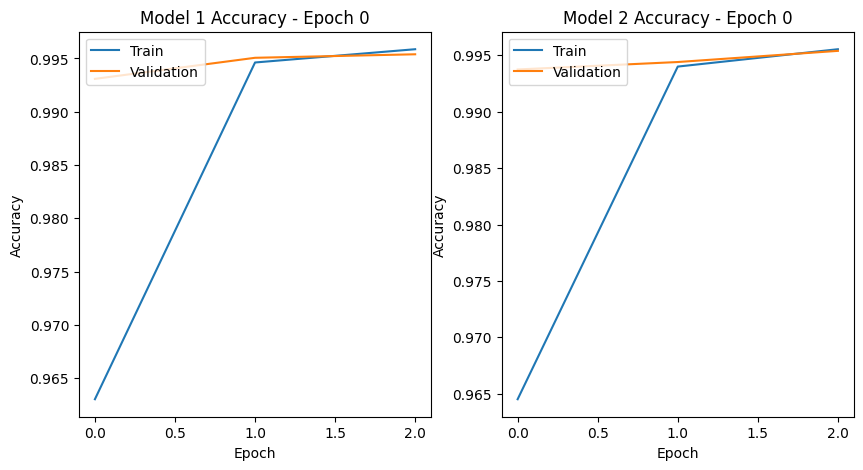

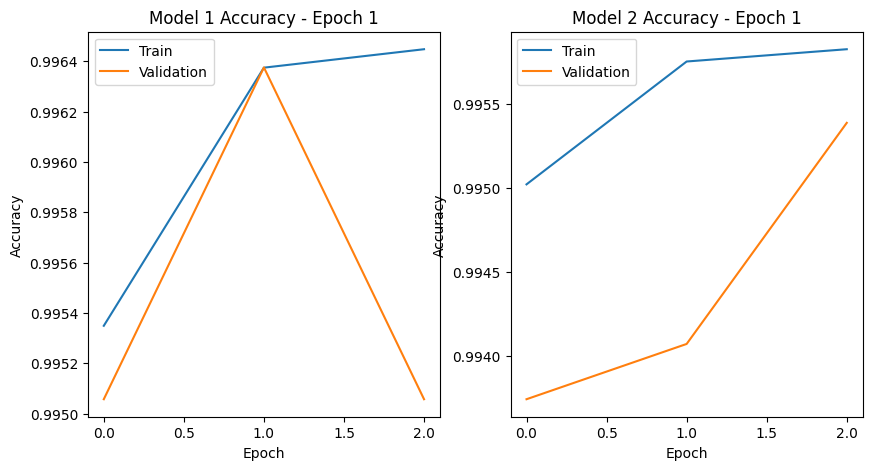

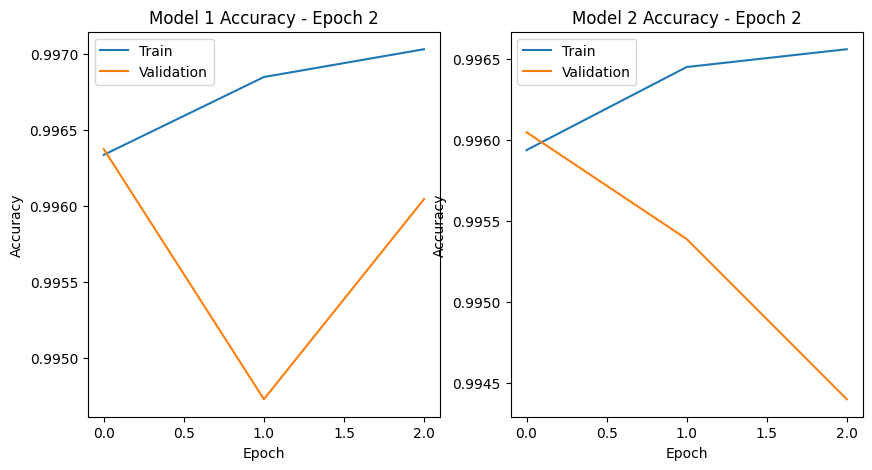

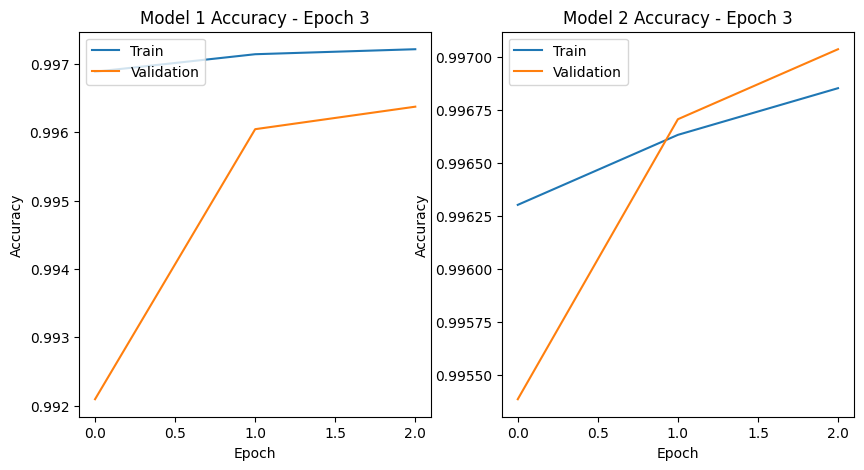

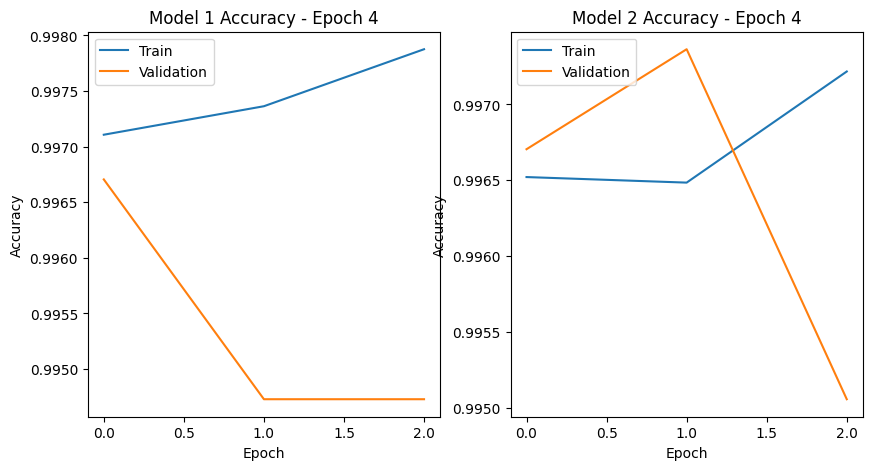

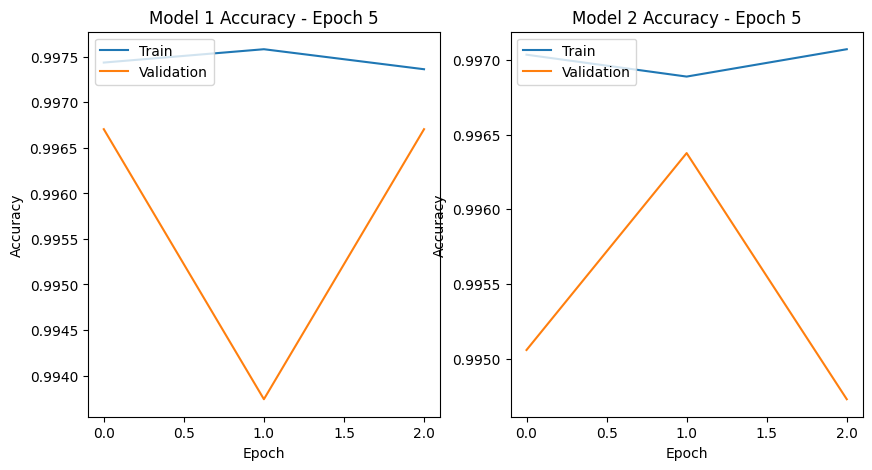

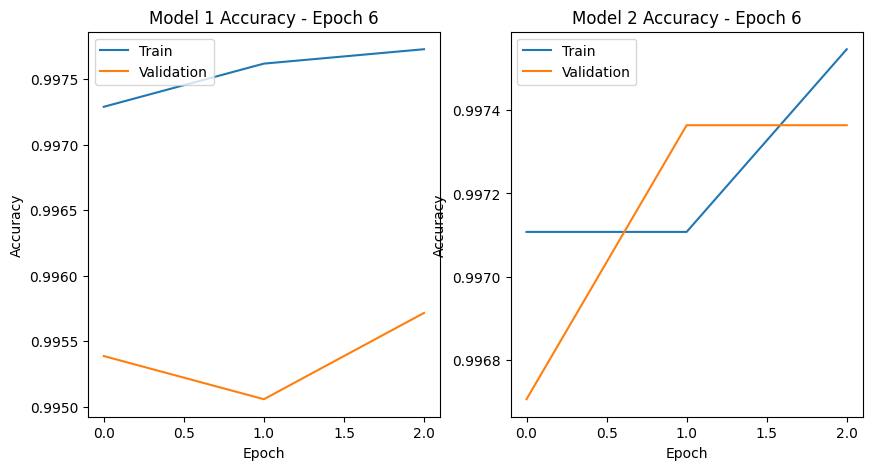

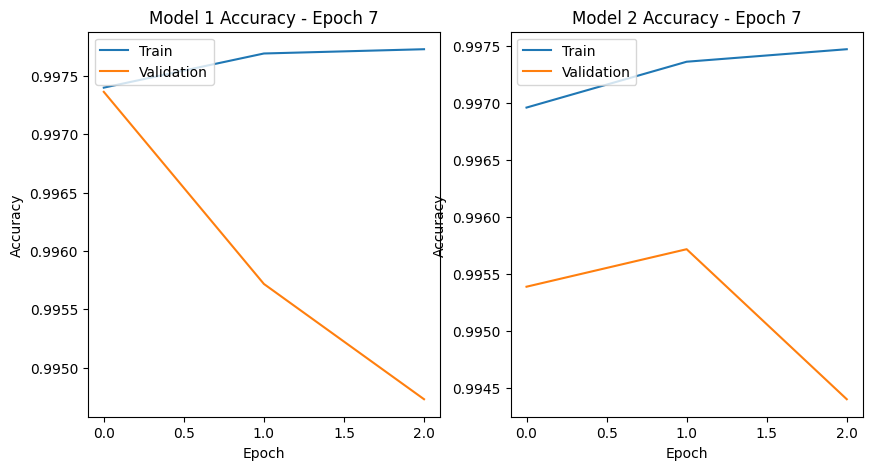

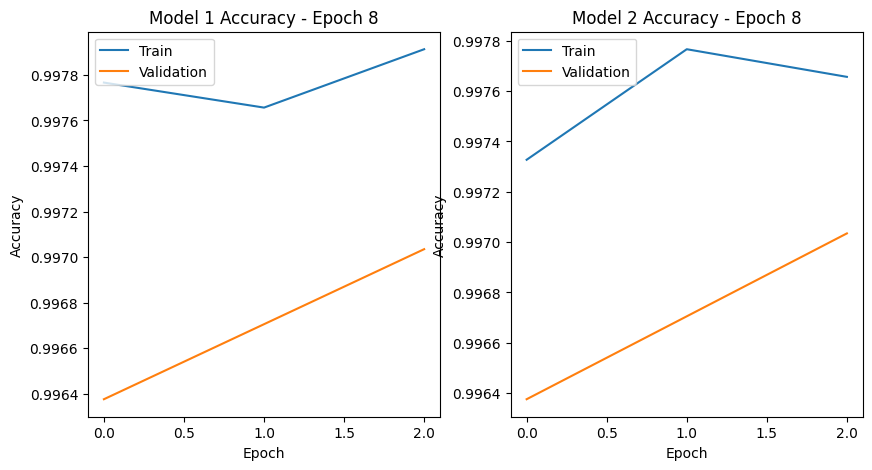

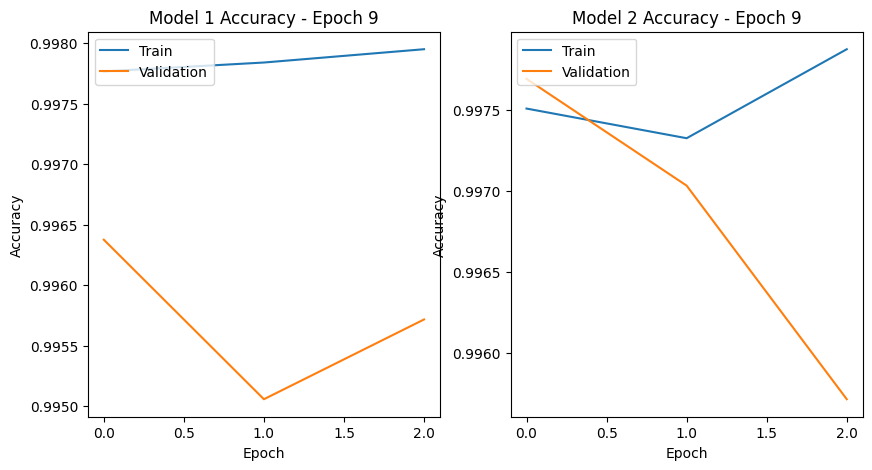

In [ ]:
# 绘制所有历史记录的图表
for i, (history1, history2) in enumerate(zip(history1_list, history2_list)):
    plt.figure(figsize=(10, 5))
    plt.subplot(1, 2, 1)
    plt.plot(history1.history['sparse_categorical_accuracy'])
    plt.plot(history1.history['val_sparse_categorical_accuracy'])
    plt.title('Model 1 Accuracy - Epoch {}'.format(i))
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Validation'], loc='upper left')

    plt.subplot(1, 2, 2)
    plt.plot(history2.history['sparse_categorical_accuracy'])
    plt.plot(history2.history['val_sparse_categorical_accuracy'])
    plt.title('Model 2 Accuracy - Epoch {}'.format(i))
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Validation'], loc='upper left')

    plt.show()



In [ ]:
import warnings
warnings.filterwarnings("ignore")
#模型评估
evaluation(model1, X_test, Y_test)


INFO:root:Evaluation:
Loss: 1527037034496.0
Accuracy : 0.9296208620071411

INFO:root:
              precision    recall  f1-score   support

           0       0.93      0.99      0.96    454620
           1       0.08      0.40      0.14       393
           2       0.98      0.99      0.98     25606
           3       0.71      0.96      0.82      2058
           4       1.00      0.98      0.99     46215
           5       0.34      0.38      0.36      1100
           6       0.93      0.39      0.55      1159
           7       0.86      1.00      0.92      1588
           8       0.03      0.00      0.00      1179
           9       0.00      0.00      0.00       302
          10       0.76      0.00      0.01     31786

    accuracy                           0.93    566006
   macro avg       0.60      0.55      0.52    566006
weighted avg       0.92      0.93      0.90    566006

INFO:root:F1 score: 0.90



In [ ]:
import warnings
warnings.filterwarnings("ignore")
#模型评估
evaluation(model2, X_test, Y_test)

INFO:root:Evaluation:
Loss: 88170790912.0
Accuracy : 0.9305642247200012

INFO:root:
              precision    recall  f1-score   support

           0       0.97      0.96      0.97    454620
           1       0.12      0.78      0.21       393
           2       0.99      0.13      0.23     25606
           3       0.39      0.93      0.55      2058
           4       0.91      1.00      0.95     46215
           5       0.48      0.71      0.58      1100
           6       0.47      1.00      0.64      1159
           7       0.99      1.00      0.99      1588
           8       0.02      1.00      0.04         2
           9       0.03      0.71      0.05         7
          10       0.77      1.00      0.87     31786
          11       0.56      1.00      0.72      1179
          12       0.04      0.20      0.07       302
          13       0.01      0.25      0.01         4
          14       0.01      0.04      0.01       130

    accuracy                           0.93    566